# Transpile circuits in a pulse-efficient way

*Estimated QPU usage: 14 seconds (tested on IBM Sherbrooke)*

## Background: What is a pulse gate?

A quantum gate is an abstraction for the operation applied to qubits. In superconducting qubit architecture, its physical implementation typically involves applying microwave pulses - these are electromagnetic waves at specific frequencies with certain amplitudes and durations - to interact with qubits and control the qubit states. Those microwave pulses are pre-calibrated to implement a desired operation and serve as one of the [standard native gates](https://docs.quantum.ibm.com/run/native-gates). The Qiskit OpenPulse feature allows users to access pulse-level control and use _pulse gates_ - gates that are specified by pulse schedules.

Pulse gates provide more flexibility in defining and fine-tuning qubit operations and could potentially be used to construct gates that have higher fidelities, particularly when translating circuits for quantum simulation with small Trotterization time steps.

## Overview

This tutorial illustrates how to transpile circuits in a pulse-efficient way by transpiling two-qubit gates into the [`RZXGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZXGate.html).  The process consists of applying echoed cross-resonance pulses with varying duration to turn on the two-qubit $Z\otimes X$ interaction. This implements the 'RZXGate' with an arbitrary rotation angle $\theta$.  Because it is implemented by directly specifying the gate's pulse-level instruction schedule and requires no further decomposition, it serves as a continuous gate set native to the hardware.

The following examples show that this method results in shorter circuit depth and duration. Because qubits have a limited coherence time, a shorter total circuit duration is desirable. 

The pulse-efficient transpilation has been shown to give more accurate results in the quantum approximate optimization algorithm applied to MAXCUT (see reference [here](https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.043088)). This notebook demonstrate how to implement the described technique to transpile a relevant circuit in simulating quantum dynamics. The result from the hardware suggests that the `RZXGate` type of transpilation produces more accurate results.

## Requirements

Before starting this tutorial, ensure that you have the following installed:

* Qiskit SDK 1.0 or later with visualization support (`pip install qiskit[visualization]`)
* Qiskit Runtime (`pip install qiskit-ibm-runtime`) 0.22 or later

In [1]:
# for circuit construction
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp

# for transpilation
from qiskit.providers import Backend
from qiskit.compiler import schedule as build_schedule
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import (Optimize1qGatesDecomposition,
                                      RZXCalibrationBuilder,
                                      FullAncillaAllocation,
                                      GateDirection,
                                      )

# for running circuits on backend
from qiskit_ibm_runtime import QiskitRuntimeService

# other basic modules
import numpy as np
import random
from typing import Dict, List
import matplotlib.pyplot as plt

To perform pulse-efficient transpilation, choose a backend that supports running OpenPulse circuits.  Currently, only the Eagle and Falcon processor families have this support. Additionally, the implementation shown in this notebook only supports backends that have `ECRGate` as the two-qubit basis gate.

In [2]:
service = QiskitRuntimeService(channel="ibm_quantum")

In [3]:
# Find a backend in the Eagle family with ECR as a basis gate

ecr_backend = service.least_busy(simulator=False, operational=True, filters=lambda b: b.configuration().processor_type['family'] == 'Eagle' and ('ecr' in b.basis_gates))

ecr_backend

<IBMBackend('ibm_sherbrooke')>

When running a generic quantum circuit on hardware, the circuits must be transpiled into a basic set of gates that are compatible with a target backend. This process is handled by the [`qiskit.transpiler`](https://qiskit.org/documentation/apidoc/transpiler.html).  This tutorial introduces two ways of defining the basis gate set:

- Standard method: Basis gate set that includes ECR gate
    `BASIS_GATES = ['ecr', 'x', 'sx', 'rz']`

- Pulse-efficient method: Basis gate set that includes the pulse RZX gate
    `BASIS_GATES = ['rzx', 'x', 'sx', 'rz']`

The standard method is to transpile into a basis gate set that includes a two-qubit entangling gate. Depending on the backend, the two-qubit entangling gate is either a `CXGate` or an `ECRGate`, which are pre-calibrated on the hardware. In practice, two-qubit entangling gates typically have longer gate times than single-qubit gates, and are a main error source. 

This tutorial transpiles into an `RZXGate` pulse gate instead. An `RZXGate` is a continuous two-qubit entangling gate with the angle $\theta$ as a gate parameter.  Its gate time adjusts accordingly. In some use cases, the transpiled circuits are shown to be pulse-efficient, that is, they have fewer two-qubit gates and a shorter circuit durations. This is beneficial because the qubits have a finite coherence time. 

There are two basic steps to transpile into an `RZXGate`:

1. Decompose the input circuit in terms of single-qubit gates and the `RZXGate`.
2. Stretch the pulse schedule according to the desired rotation angle and attach the new schedule to the `RZXGate`s.

## Step 1: Map classical inputs to a quantum problem

First, build the Trotterized evolution. The following circuit example simulates the dynamics generated by the Hamiltonian $H = - J \sum_{i,j}Z_i\otimes Z_j + h\sum_{i}X_i$. To approximate the dynamics, implement its Trotterized evolution by using a [`PauliEvolutionGate`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliEvolutionGate.html) parametrized by $J$, $h$ and the Trotterized time step $t$.

Following is a simple example circuit on two qubits:

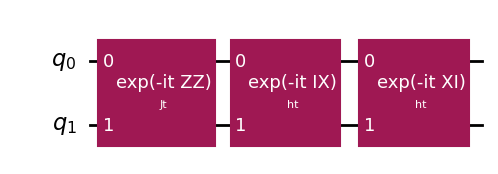

In [4]:
def build_trotter_evolution(num_qubits: int, rep = 1):
    Jt = Parameter('Jt')
    ht = Parameter('ht')
    qr = QuantumRegister(num_qubits, 'q')
    qc = QuantumCircuit(qr)
    even_indices = [i for i in range(0, num_qubits-1, 2)]
    odd_indices = [i for i in range(1, num_qubits-1, 2)]
    for _ in range(rep):
        for i in odd_indices + even_indices:
            ZZ_term = 'I' * (num_qubits - i - 2) + 'ZZ' + 'I' * i
            UU = PauliEvolutionGate(SparsePauliOp([ZZ_term]), time=Jt)
            qc.append(UU, qr)
        for i in range(num_qubits):
            X_term = 'I' * (num_qubits - i - 1) + 'X' + 'I' * i
            UU = PauliEvolutionGate(SparsePauliOp([X_term]), time=ht)
            qc.append(UU, qr)
    return qc

qc = build_trotter_evolution(num_qubits=2)
qc.draw('mpl', fold=-1)

## Step 2: Optimize problem for quantum execution

Optimizing the problem for quantum execution involves transpiling the circuits.  For comparison, transpile by using both of the previously described methods:
* Transpile to the standard gate set with the `ECR` gate.
* Transpile into a basis gate set with `RZXGate`.

After transpilation, compare the two-qubit circuit depth of the output circuits. You only need to compare the two-qubit gates because their longer gate times and higher error rates make them more costly. 

ECR-transpiled two-qubit circuit depth = 2


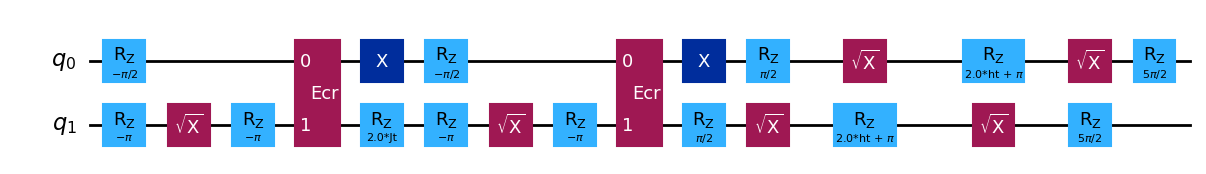

In [5]:
# Transpile into ECR gates (standard method)
ecr_pm = generate_preset_pass_manager(basis_gates=['ecr', 'x', 'sx', 'rz'], optimization_level=1)
ecr_circ = ecr_pm.run(qc)
print(f'ECR-transpiled two-qubit circuit depth = {ecr_circ.depth(lambda x: x[0].num_qubits == 2)}')
ecr_circ.draw('mpl')

RZX-transpiled two-qubit circuit depth = 1


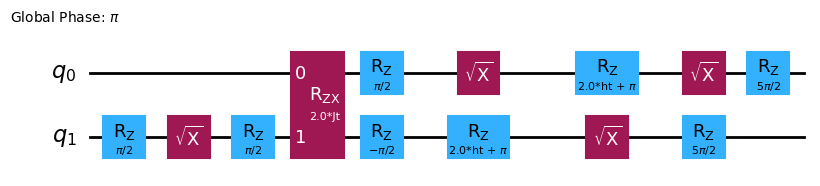

In [6]:
# transpile into RZX gates
rzx_pm = generate_preset_pass_manager(basis_gates=['rzx', 'x', 'sx', 'rz'], optimization_level=1)
rzx_circ = rzx_pm.run(qc)
print(f'RZX-transpiled two-qubit circuit depth = {rzx_circ.depth(lambda x: x[0].num_qubits == 2)}')
rzx_circ.draw('mpl', fold=-1)

The RZX transpilation results in only one `RZXGate`, which effectively shortens the two-qubit circuit depth by half compared to the `ECR` transpilation. In fact, this is a general result: any two-qubit unitary can be represented in the `RZXGate` decomposition with at most three `RZXGate`s by using the so-called [KAK decomposition](https://arxiv.org/abs/quant-ph/0507171).

### Create a custom pulse gate

Notice that in the `RZXGate` transpiled circuit, the `RZXGate`s are parameterized by the angle `Jt.` To properly implement the gate, you need to supply the hardware with the correct pulse schedule. To do this, create a custom [pulse gate](https://docs.quantum.ibm.com/build/pulse) by attaching a stretched pulse schedule to the `RZXGate` based on the desired entangling angle. 

First, transpile the circuit for the backend, then assign values to the circuit parameters.

In [7]:
J = 1
h = 0
t = random.uniform(0,np.pi)
params = rzx_circ.parameters
circ_params = {params[0]: J * t,
               params[1]: h * t}
# Bind the paramter to the circuit
rzx_circ.assign_parameters(circ_params, inplace=True)

The transpiler pass [`RZXCalibrationBuilder`](https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.RZXCalibrationBuilder.html) can be used to attach the pulse schedule to the `RZXGate` by stretching the pre-calibrated pulse schedule for the ECR gate. This calibration information is stored in an [`InstructionScheduleMap`](https://docs.quantum.ibm.com/api/qiskit/qiskit.pulse.InstructionScheduleMap) object and is available for each backend. 

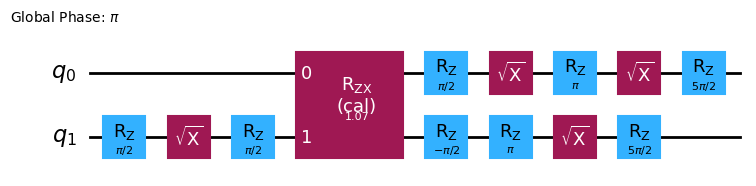

In [8]:
inst_sched_map = ecr_backend.defaults().instruction_schedule_map
channel_map = ecr_backend.configuration().qubit_channel_mapping
pass_manager = PassManager([RZXCalibrationBuilder(inst_sched_map, channel_map)])
rzx_circ = pass_manager.run(rzx_circ)
rzx_circ.draw('mpl', fold=-1)

Not all two-qubit unitaries will result in shorter circuit durations. It depends on the circuit parameters. To illustrate this, transpile for different parameters and get the circuit duration by [building pulse schedules](https://docs.quantum.ibm.com/build/pulse) for the transpiled circuit.

### Estimate circuit duration

In [9]:
# transpile to ECR and get circuit duration
def cal_ecr_circ_duration(circuit: QuantumCircuit, backend: Backend, params: Dict) -> int:
    # transpile circuit into ecr basis gate, get duration
    pm = generate_preset_pass_manager(basis_gates=['ecr', 'x', 'sx', 'rz'], optimization_level=1)
    ecr_circ = pm.run(circuit)
    # modify ECR gate direction according to the backend
    pass_manager = PassManager([
        GateDirection(coupling_map = backend.coupling_map),
        Optimize1qGatesDecomposition(backend.operation_names)
    ])
    ecr_circ = pass_manager.run(ecr_circ)
    # assign parameters
    parameters = ecr_circ.parameters
    params_dict = {parameters[0]: params['Jt'],
                parameters[1]: params['ht']}
    ecr_circ.assign_parameters(params_dict, inplace=True)
    # schedule
    circuits_transpiled = build_schedule(ecr_circ, backend)
    return circuits_transpiled.duration

# transpile to rzx and get circuit duration
def cal_rzx_circ_duration(circuit: QuantumCircuit, backend: Backend, params: Dict):
    # transpile
    pm = generate_preset_pass_manager(basis_gates=['rzx', 'x', 'sx', 'rz'], optimization_level=1)
    rzx_circ = pm.run(circuit)
    # assign parameters
    parameters = rzx_circ.parameters
    params_dict = {parameters[0]: params['Jt'],
                   parameters[1]: params['ht']}
    rzx_circ.assign_parameters(params_dict, inplace=True)
    # attach schedule
    inst_sched_map = backend.instruction_schedule_map
    channel_map = backend.configuration().qubit_channel_mapping
    pass_manager = PassManager([RZXCalibrationBuilder(inst_sched_map, channel_map)])
    rzx_circ = pass_manager.run(rzx_circ)
    # schedule
    rzx_schedule = build_schedule(rzx_circ, backend)
    # return rzx_schedule.duration
    return rzx_schedule.duration

Sweep the entangling angle from $0$ to $\pi$ and compare which transpilation gives shorter circuit durations - the standard `ECR` transpilation or the `RZXGate` transpilation. 

In [10]:
angles = np.linspace(0, np.pi, 100)
ecr_durations = [cal_ecr_circ_duration(qc, ecr_backend, {'Jt': J*t, 'ht': h*t}) for t in angles]
rzx_durations = [cal_rzx_circ_duration(qc, ecr_backend, {'Jt': J*t, 'ht': h*t}) for t in angles]

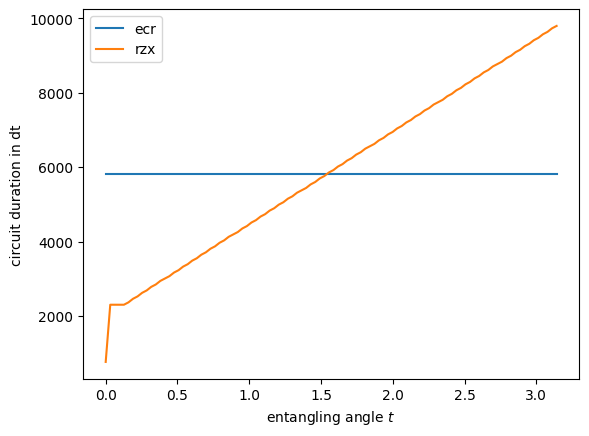

In [11]:
plt.plot(angles, ecr_durations,label='ecr')
plt.plot(angles, rzx_durations, label='rzx')
plt.xlabel(r'entangling angle $t$')
plt.ylabel('circuit duration in dt')
plt.legend()

As shown in the plot above, the `RZXGate` transpilation results in shorter circuit durations for small entangling angles.

### A larger example

Extend the example to a one-dimensional spin chain of $N=21$ qubits. Follow the previously described steps to transpile into a basis gate set that includes either an `ECR` or an `RZX` gate. This is what the Trotterized evolution circuit looks like:

In [12]:
num_qubits = 21
evol = build_trotter_evolution(num_qubits=num_qubits, rep=10)

Initialize the qubit state in the `0101...01` antiferromagnetic state, then compose the evolution circuit `evol` after the state initialization. Finally, assign circuit parameters $Jt=0.1$ and $ht=0$. 

In [13]:
qr = QuantumRegister(num_qubits, 'q')
qc = QuantumCircuit(qr)
# state initialization
for i in range(0, num_qubits, 2):
    qc.x(i)

# evolve
qc.compose(evol, inplace=True)

# assign parameters
parameters = qc.parameters
qc.assign_parameters({parameters[0]: 0.1, parameters[1]: 0}, inplace=True)

#### Transpile

This example is transpiled to run on the selected backend. Define two functions: one to transpile into a basis gate set that includes the `ECR` gate, and the other includes the `RZX` gate.

In [14]:
def transpile_to_ecr(circuit: QuantumCircuit,
                    layout: List,
                     backend: Backend):
    BASIS_GATES = ['ecr', 'x', 'sx', 'rz']
    # transpile
    pm = generate_preset_pass_manager(backend=backend, initial_layout=layout, layout_method='trivial', optimization_level=1)
    ecr_circ = pm.run(circuit)
    print(f'ECR transpile: two-qubit circuit depth = {ecr_circ.depth(lambda x: x[0].num_qubits == 2)}')
    return ecr_circ

def transpile_to_rzx(circuit: QuantumCircuit,
                     layout: List,
                     backend: Backend):
    BASIS_GATES = ['rzx', 'x', 'sx', 'rz']
    # transpile
    pm = generate_preset_pass_manager(basis_gates= BASIS_GATES, coupling_map=backend.coupling_map, initial_layout=layout, layout_method='trivial',  optimization_level=1)
    rzx_circ = pm.run(qc)
    # optimize 1q
    pm = PassManager([Optimize1qGatesDecomposition(["rzx", "x", "sx", "rz" ])])
    rzx_circ = pm.run(rzx_circ)
    # attach schedule
    inst_sched_map = backend.defaults().instruction_schedule_map
    channel_map = backend.configuration().qubit_channel_mapping

    pass_manager = PassManager([
                                RZXCalibrationBuilder(inst_sched_map, channel_map)],
                                FullAncillaAllocation(CouplingMap(backend.configuration().coupling_map)))
    rzx_circ = pass_manager.run(rzx_circ)
    print(f'RZX transpile: two-qubit circuit depth = {rzx_circ.depth(lambda x: x[0].num_qubits == 2)}')
    return rzx_circ

In [15]:
# map to physical qubits that form 1D chain
layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 30, 31, 32, 36, 51, 50, 49]

# transpile into ECR gates
ecr_circ = transpile_to_ecr(qc, layout=layout, backend=ecr_backend)
print(f'ECR circuit duration: {build_schedule(ecr_circ, ecr_backend).duration*ecr_backend.dt*10**6} us')
# transpile into RZX gates
rzx_circ = transpile_to_rzx(qc, layout=layout, backend=ecr_backend)
print(f'RZX circuit duration: {build_schedule(rzx_circ, ecr_backend).duration*ecr_backend.dt*10**6} us')


ECR transpile: two-qubit circuit depth = 40
ECR circuit duration: 24.803555555555555 us
RZX transpile: two-qubit circuit depth = 20
RZX circuit duration: 5.745777777777778 us


After transpilation, notice the following:
* Virtual qubits are mapped to physical qubits, and the transpiled circuits `ecr_circ` and `rzx_circ` are defined over all physical qubits.
* Gates are parsed in the basis gates. In the `rzx` based transpilation, all `RZXGate`s should have calibrations attached.

## Step 3: Execute using Qiskit Runtime primitives

Run the `RZX`-based transpiled circuit on the hardware by using Qiskit Runtime. To compare, run the `ECR`-based transpiled circuit as well. 

In [16]:
rzx_circ.layout

In [17]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
obs = SparsePauliOp('ZZ' + 'I' * (num_qubits - 2))
# Transpile the observable
ecr_obs= obs.apply_layout(ecr_circ.layout)
rzx_obs= obs.apply_layout(rzx_circ.layout)
shots = 10000

with Session(backend=ecr_backend):
    session_options = EstimatorOptions()
    session_options.default_shots = shots
    session_options.resilience_level = 1
    estimator = Estimator(session=Session(service, backend=ecr_backend), options=session_options)
    rzx_job_zz = estimator.run([(rzx_circ, ecr_obs)])
    ecr_job_zz = estimator.run([(ecr_circ, ecr_obs)])
    rzx_result = rzx_job_zz.result()
    ecr_result = ecr_job_zz.result()

## Step 4: Post-process, return the result in classical format

Note that under the condition $ht=0$, the Hamiltonian evolution preserves the initial $Z_iZ_{i+1}$ correlation, hence we know the exact value of ZZ correlation is -1. From the comparison below, the RZX-based pulse-efficient transpilation gives results closer to the exact value due to shorter circuit durations.  

In [18]:
### Compare exact, standard ECR-based transpilation, vs RZX-based transpilation
print(f'exact_value = -1')

print(f'rzx_value = {rzx_result[0].data.evs}' + ' +/- ' + f'{rzx_result[0].data.stds}')
print(f'ecr_value = {ecr_result[0].data.evs}' + ' +/- ' + f'{ecr_result[0].data.stds}')

exact_value = -1
rzx_value = -0.25979831446640106 +/- 0.011251047121804244
ecr_value = -0.04765434852490635 +/- 0.007628237767692864


In this example, transpiling to RZX gates gives better results than transpiling to ECR gates.  The circuit used is relatively deep, and while the ECR method loses the signal at `resilience_level=1`, the RZX method retains some signal in the initial correlation.  Note that this is an experimental feature and the performance depends on a various factors, including the accuracy of the calibration data used to construct the RZX gates.  You are encouraged to try it out for your use cases.